# AA on toy data

Device:  cuda


  2%|▏         | 192/10000 [00:00<00:31, 312.16it/s]


Tolerance reached at 193 number of iterations


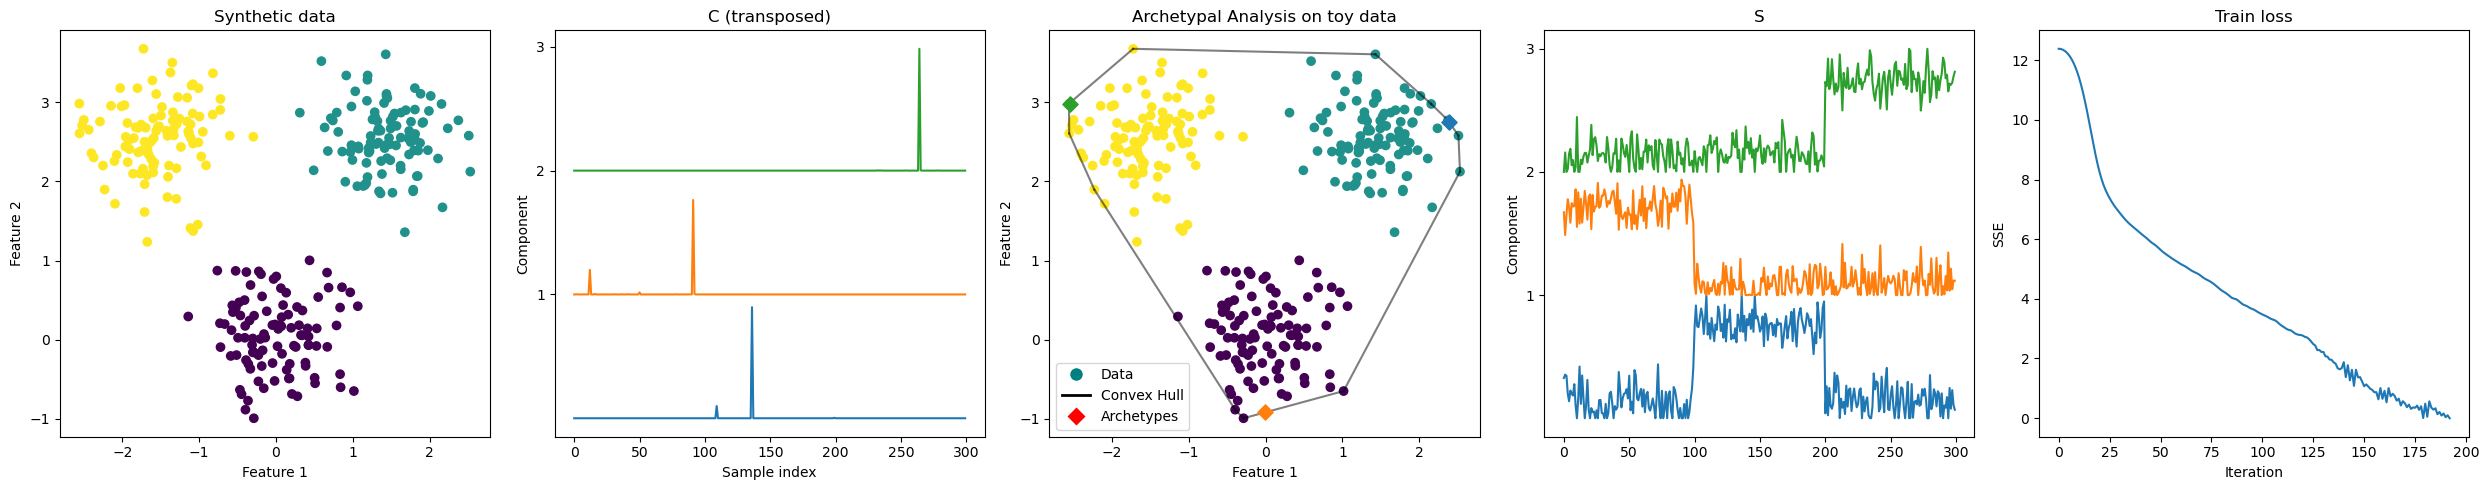

In [1]:
import sys
sys.path.append('../')
from src.CGD import AA_model, AA_trainer
from scipy.spatial import ConvexHull
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.utils.AA_visualize import plot_AA, plot_AA_simple, plot_AA_reconstructed, plot_AA_reconstructed_angle

# make 3 blobs of data using multivariate normal distribution
np.random.seed(0)
var = 0.2
n = 100
rad = (np.cos(30/(180/np.pi))*3)
X1 = np.random.multivariate_normal([0,0],[[var,0],[0,var]],n).T
X2 = np.random.multivariate_normal([1.5,rad],[[var,0],[0,var]],n).T
X3 = np.random.multivariate_normal([-1.5,rad],[[var,0],[0,var]],n).T

X = np.concatenate((X1,X2,X3),axis=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = torch.tensor(X).to(device)

# scatter each label
labels = np.concatenate((np.zeros(n),np.ones(n),2*np.ones(n))).astype(int)

# initialize an AA model with 4 components, where the data is provided in a dictionary
K = 3
model = AA_model.AA(X=data,num_comp=K,model='AA')

# specify an optimizer (don't set LR too high)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# train the model, the model stops training when the difference between lowest and second-lowest of the 5 latest losses is less than 1e-8
loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6)

# get and detach parameters
C,S = model.get_model_params()
    
# plots
plot_AA(X,C,S,K,loss,labels)

In [2]:
X.shape, C.shape, S.shape

((2, 300), (300, 3), (3, 300))

### C, Archetype, and S plot

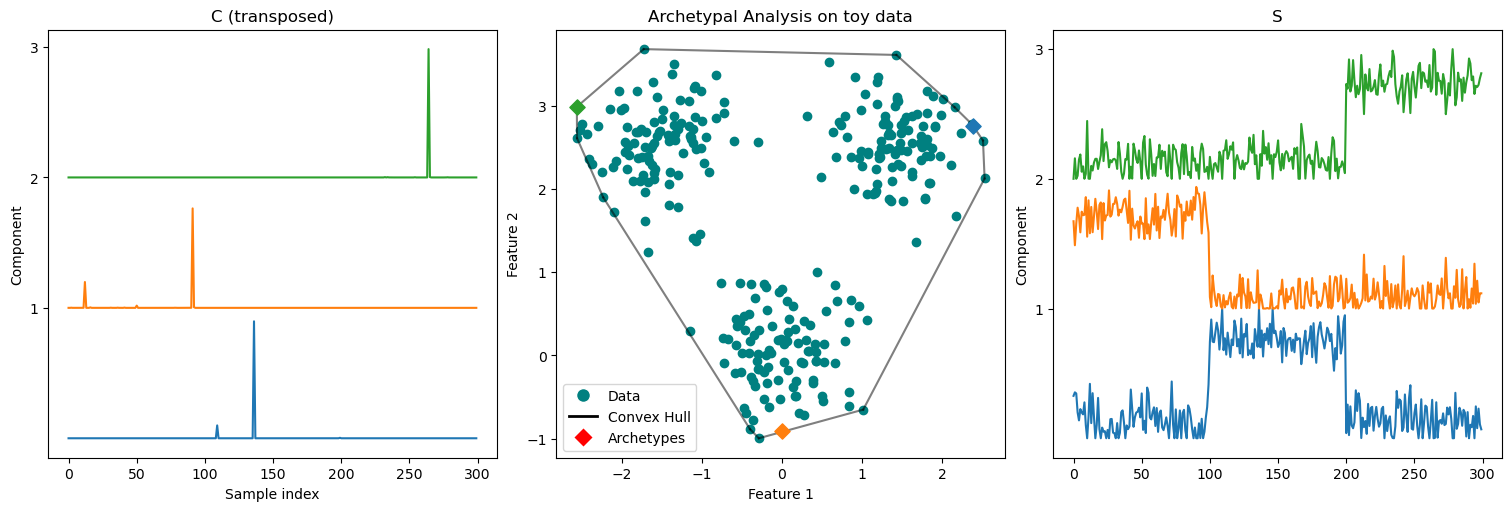

In [3]:
plot_AA_simple(X,C,S,K)

100%|██████████| 3/3 [00:29<00:00,  9.81s/it]


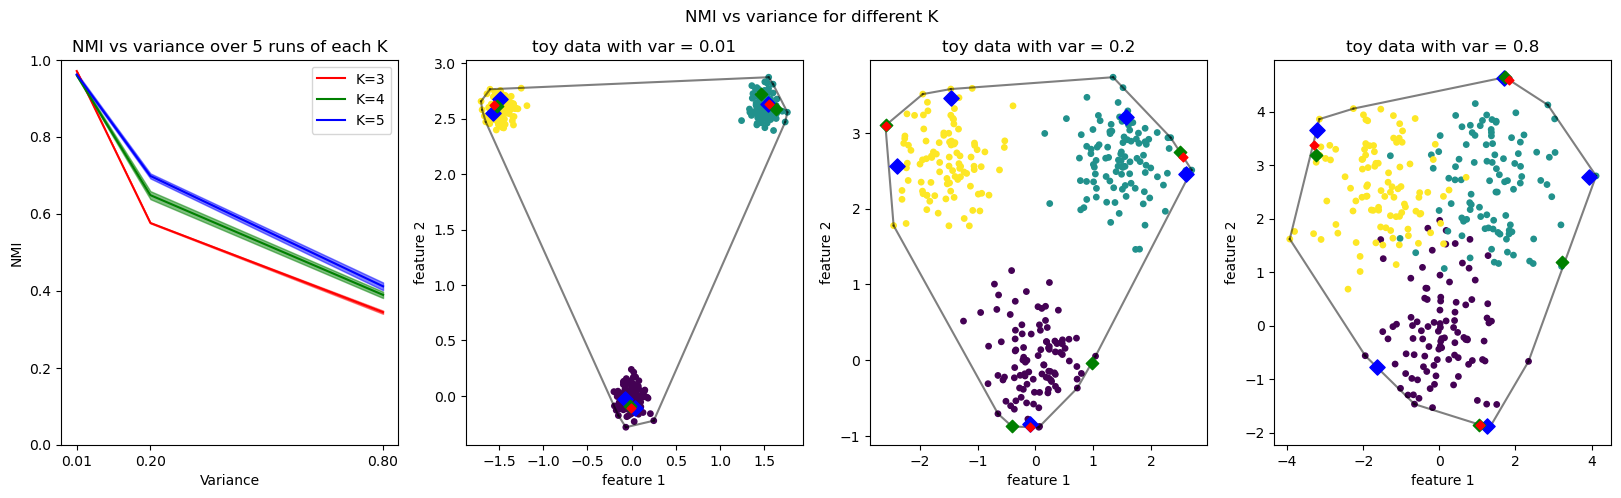

In [4]:
vars = [0.01, 0.2, 0.8]
n = 100
rad = (np.cos(30/(180/np.pi))*3)

from src.utils.stat_functions import calculate_NMI

NMI_list_score = [[] for i in range(3)]
NMI_list_std = [[] for i in range(3)]
from tqdm import tqdm

fig, axs = plt.subplots(1,4,figsize=(20,5))
fig.suptitle('NMI vs variance for different K')

for i, var in enumerate(vars):
    # scatter each label
    X1 = np.random.multivariate_normal([0,0],[[var,0],[0,var]],n).T
    X2 = np.random.multivariate_normal([1.5,rad],[[var,0],[0,var]],n).T
    X3 = np.random.multivariate_normal([-1.5,rad],[[var,0],[0,var]],n).T

    X = np.concatenate((X1,X2,X3),axis=1)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = torch.tensor(X).to(device)

    labels = np.concatenate((np.zeros(n),np.ones(n),2*np.ones(n))).astype(int)
    labels2 = np.eye(3)[labels].T


    axs[i+1].scatter(X[0,:],X[1,:],c=labels,s=15)
    axs[i+1].set_title('toy data with var = ' + str(var))
    axs[i+1].set_xlabel('feature 1')
    axs[i+1].set_ylabel('feature 2')

    hull = ConvexHull(X.T)
    for simplex in hull.simplices:
        axs[i+1].plot(X[0,simplex],X[1,simplex],'k-', alpha=0.5)

    colors = ['r','g','b']

    for j, K in enumerate(tqdm([3,4,5])):
        NMI_score = []

        for _ in range(5):
            model = AA_model.AA(X=data,num_comp=K,model='AA',verbose=False)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
            loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=1500,tol=1e-6,disable_output=True)
            C,S = model.get_model_params()
            NMI_score.append(calculate_NMI(S,labels2))

        NMI_list_score[j].append(np.mean(NMI_score))
        NMI_list_std[j].append(np.std(NMI_score)/np.sqrt(5))

        XC = X @ C
        axs[i+1].scatter(XC[0,:],XC[1,:], c=colors[j], label='K = ' + str(K), s=20+20*j, zorder=5-j, marker='D')

# make 3 lineplots of NMI vs variance
axs[0].plot(vars,NMI_list_score[0],label='K=3', color='r')
axs[0].fill_between(vars, np.array(NMI_list_score[0])-np.array(NMI_list_std[0]), np.array(NMI_list_score[0])+np.array(NMI_list_std[0]), alpha=0.5, color='r')
axs[0].plot(vars,NMI_list_score[1],label='K=4', color='g')
axs[0].fill_between(vars, np.array(NMI_list_score[1])-np.array(NMI_list_std[1]), np.array(NMI_list_score[1])+np.array(NMI_list_std[1]), alpha=0.5, color='g')
axs[0].plot(vars,NMI_list_score[2],label='K=5', color='b')
axs[0].fill_between(vars, np.array(NMI_list_score[2])-np.array(NMI_list_std[2]), np.array(NMI_list_score[2])+np.array(NMI_list_std[2]), alpha=0.5, color='b')
axs[0].set_xlabel('Variance')
axs[0].set_ylabel('NMI')
axs[0].set_ylim([0,1])
axs[0].legend()
axs[0].set_title('NMI vs variance over 5 runs of each K')

#xticks = var
axs[0].set_xticks(vars)

plt.show()

### Datapoints represented by Archetypes

Device:  cuda


 13%|█▎        | 1266/10000 [00:01<00:12, 724.46it/s]


Tolerance reached at 1267 number of iterations


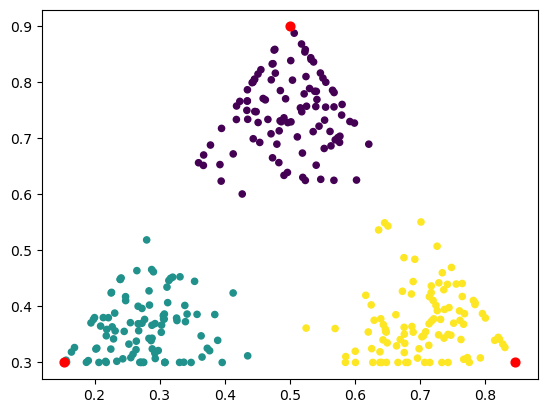

In [5]:
K = 3
model = AA_model.AA(X=data,num_comp=K,model='AA')
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6)

C, S = model.get_model_params()

plot_AA_reconstructed(X, C, S, K, y=labels, recon_order_points=10, point_size=20)

# Data Loading

In [39]:
import sys
sys.path.append('../')
from src.CGD import AA_model, AA_trainer
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.preprocessing import load_data, load_config

# slowdelta, fastdelta, slowtheta, fasttheta, alpha, beta, rms, mouseID, lab, sleepstage, epoch
config = load_config()
data_path = config['data_path']
df = load_data(data_path, verbose=False)
# unique id, L{lab},M{mouseID}
df['unique_id'] = df['lab'].astype(str) + '_' + df['mouseID'].astype(str)
df['unique_id'] = df['unique_id'].astype('category').cat.codes + 1
df = df.sort_values('unique_id')
df

,slowdelta,fastdelta,slowtheta,fasttheta,alpha,beta,rms,mouseID,lab,sleepstage,epoch,unique_id
0,0.286260,0.175425,0.207455,0.125388,0.108024,0.058404,0.338769,1.0,1.0,3.0,1.0,1
41184,0.090378,0.370615,0.240097,0.081554,0.140792,0.067703,0.414360,1.0,1.0,3.0,43255.0,1
41185,0.411872,0.127013,0.172795,0.062764,0.082301,0.047648,0.406009,1.0,1.0,3.0,43256.0,1
41186,0.260672,0.200171,0.164967,0.081898,0.154101,0.060435,0.418746,1.0,1.0,3.0,43257.0,1
41187,0.162809,0.091261,0.266165,0.132450,0.177477,0.041848,0.412606,1.0,1.0,3.0,43258.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1879140,0.337924,0.231237,0.068860,0.054589,0.092746,0.072120,0.109166,9.0,5.0,3.0,7178.0,150
1879139,0.307003,0.264140,0.142889,0.045048,0.051583,0.073142,0.663739,9.0,5.0,3.0,7177.0,150
1879138,0.404338,0.274106,0.076717,0.036097,0.089673,0.053889,0.103816,9.0,5.0,3.0,7176.0,150
1879146,0.164438,0.372611,0.219474,0.050206,0.135191,0.061387,0.105354,9.0,5.0,3.0,7184.0,150


In [43]:
# round to 2 decimals
df.describe().round(3)

,slowdelta,fastdelta,slowtheta,fasttheta,alpha,beta,rms,mouseID,lab,sleepstage,epoch,unique_id
count,1958291.000,1958291.000,1958291.000,1958291.000,1958291.000,1958291.000,1958291.000,1958291.000,1958291.000,1958291.000,1958291.000,1958291.000
mean,0.205,0.181,0.229,0.099,0.132,0.128,0.591,19.656,2.510,2.360,15678.895,56.718
std,0.141,0.102,0.105,0.067,0.067,0.088,0.466,16.818,1.247,0.592,16338.268,44.852
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,1.000,1.000,1.000,1.000
25%,0.100,0.100,0.150,0.050,0.080,0.070,0.220,5.000,1.000,2.000,3575.000,8.000
50%,0.170,0.160,0.220,0.080,0.120,0.110,0.450,12.000,3.000,2.000,9973.000,63.000
75%,0.270,0.240,0.290,0.120,0.170,0.170,0.900,33.000,3.000,3.000,19965.000,86.000
max,0.970,0.970,0.970,0.800,0.860,0.980,35.550,55.000,5.000,3.000,64845.000,150.000


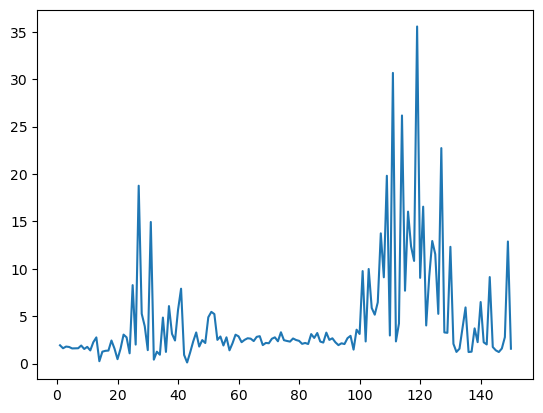

In [7]:
# max of rms for each unique_id
max_rms = df.groupby('unique_id')['rms'].max()
# plot it 
plt.plot(max_rms)

### Only using data from Lab 1

In [8]:
import os
lab1 = df[df['lab'] == 1]
lab1 = lab1.drop(columns=['mouseID', 'lab', 'unique_id', 'epoch'])
# sort data by sleepstage
lab1 = lab1.sort_values('sleepstage')
lab1np = lab1.to_numpy()
# save the data to npy file
np.save("../src/data/lab1.npy", lab1np)

### Only using data from Mouse 1

In [9]:
mouse1 = df[df['unique_id'] == 1]
mouse1 = mouse1.drop(columns=['mouseID', 'lab', 'unique_id', 'epoch'])
# sort data by sleepstage
mouse1 = mouse1.sort_values('sleepstage')
mouse1np = mouse1.to_numpy()
# save the data to npy file
np.save("../src/data/mouse1.npy", mouse1np)

# Importing data from subgroups

In [10]:
import sys
sys.path.append('../')
from src.CGD import AA_model, AA_trainer
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

load = np.load('../src/data/mouse1.npy')
df = pd.DataFrame(load, columns=['slowdelta', 'fastdelta', 'slowtheta', 'fasttheta', 'alpha', 'beta', 'rms', 'sleepstage'])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# df['rms'] = scaler.fit_transform(df[['rms']])
# log transform rms
# df['rms'] = np.log(df['rms'])
df

,slowdelta,fastdelta,slowtheta,fasttheta,alpha,beta,rms,sleepstage
0,0.055177,0.022421,0.550161,0.367579,0.078638,0.078365,0.180405,1.0
1,0.063190,0.248378,0.504500,0.048318,0.068581,0.073820,0.182802,1.0
2,0.133887,0.095840,0.540771,0.067054,0.054760,0.079849,0.287058,1.0
3,0.204722,0.108257,0.321744,0.237832,0.133263,0.094630,0.235598,1.0
4,0.117590,0.164030,0.383174,0.016218,0.118788,0.165348,0.232926,1.0
...,...,...,...,...,...,...,...,...
61781,0.180589,0.365361,0.180592,0.017467,0.079456,0.079217,0.273614,3.0
61782,0.059996,0.407746,0.292023,0.085346,0.101408,0.082046,0.581627,3.0
61783,0.179479,0.170030,0.327381,0.074890,0.040118,0.092823,0.650724,3.0
61784,0.296662,0.152067,0.226299,0.098504,0.147794,0.068712,0.378706,3.0


<Axes: title={'center': 'rms'}, xlabel='sleepstage'>

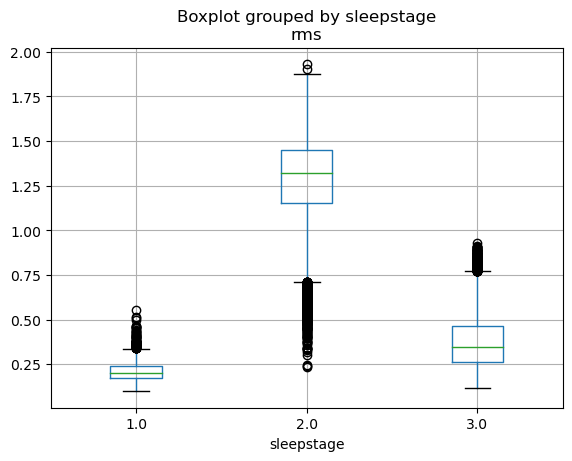

In [11]:
# boxplot of rms
df.boxplot(column='rms', by='sleepstage')

In [12]:
X = df.drop(columns=['sleepstage'])
y = df['sleepstage']
X = X.to_numpy()
y = y.to_numpy()
X = X.T

# Using a subset of the data

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Equal amount of data per sleepstage
idx = []
for i in range(1, 4):
    idx.extend(np.random.choice(np.where(y == i)[0], 30000))

# Random data
# n = len(y)
# idx = np.random.choice(len(y), n, replace=False)

sorted_idx = np.sort(idx)
X = X[:, sorted_idx]
data = torch.tensor(X).to(device)
y = (y[sorted_idx]).astype(int)

X.shape

(7, 90000)

In [14]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# data = {'X': torch.tensor(mouse1X).to(device)}
# mouse1X.shape

### Hypnogram of sleepstages (sorted)

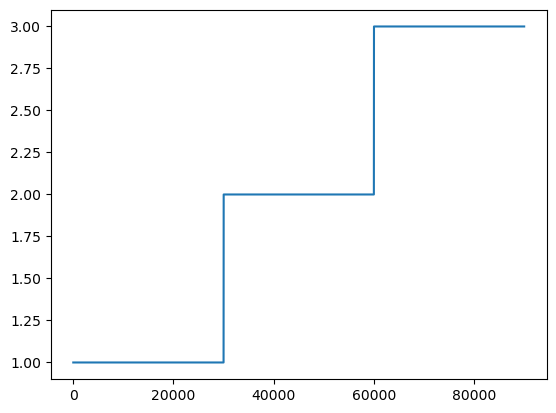

In [15]:
# Hypno of mouse 1
plt.plot(y)
plt.show()

# Training a single AA model

In [16]:
data = torch.tensor(X).to(device)

In [17]:
K = 4
model = AA_model.AA(X=data, num_comp=K, model='AA')
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6, disable_output=False)
C, S = model.get_model_params()

Device:  cuda


  5%|▌         | 537/10000 [00:07<02:13, 70.62it/s]

Tolerance reached at 538 number of iterations


In [18]:
X.shape, C.shape, S.shape

((7, 90000), (90000, 4), (4, 90000))

### Archetype coordinates

In [19]:
X@C

array([[0.01505449, 0.41887428, 0.45357141, 0.02210969],
       [0.67845604, 0.04751351, 0.21464721, 0.04768538],
       [0.13943882, 0.19921495, 0.05227867, 0.58092049],
       [0.02723239, 0.09536354, 0.0891006 , 0.17145229],
       [0.05969537, 0.08702209, 0.10756908, 0.13402205],
       [0.05441568, 0.08222634, 0.05406901, 0.11300532],
       [0.84718548, 1.75467007, 0.17662052, 0.13765442]])

### Plot of archetypes projected on the 2D/3D space

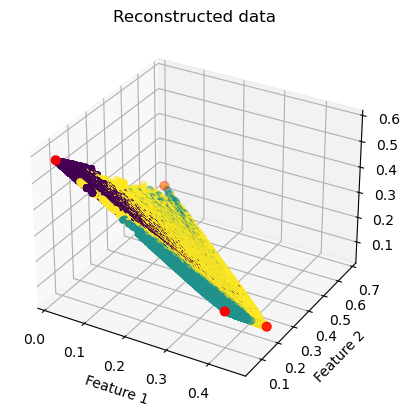

In [20]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
XC = X@C
X_reconstructed = XC@S

# 2d plot
# plt.scatter(X_reconstructed[0,:], X_reconstructed[1,:], c=y)
# plt.scatter(XC[0,:], XC[1,:], c='r', s=40, zorder=2)
# plt.title('Reconstructed data')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reconstructed[0,:], X_reconstructed[1,:], X_reconstructed[2,:], c=y)
ax.scatter(XC[0,:], XC[1,:], XC[2,:], c='r', s=40, zorder=2)
plt.title('Reconstructed data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Plot of matrix S

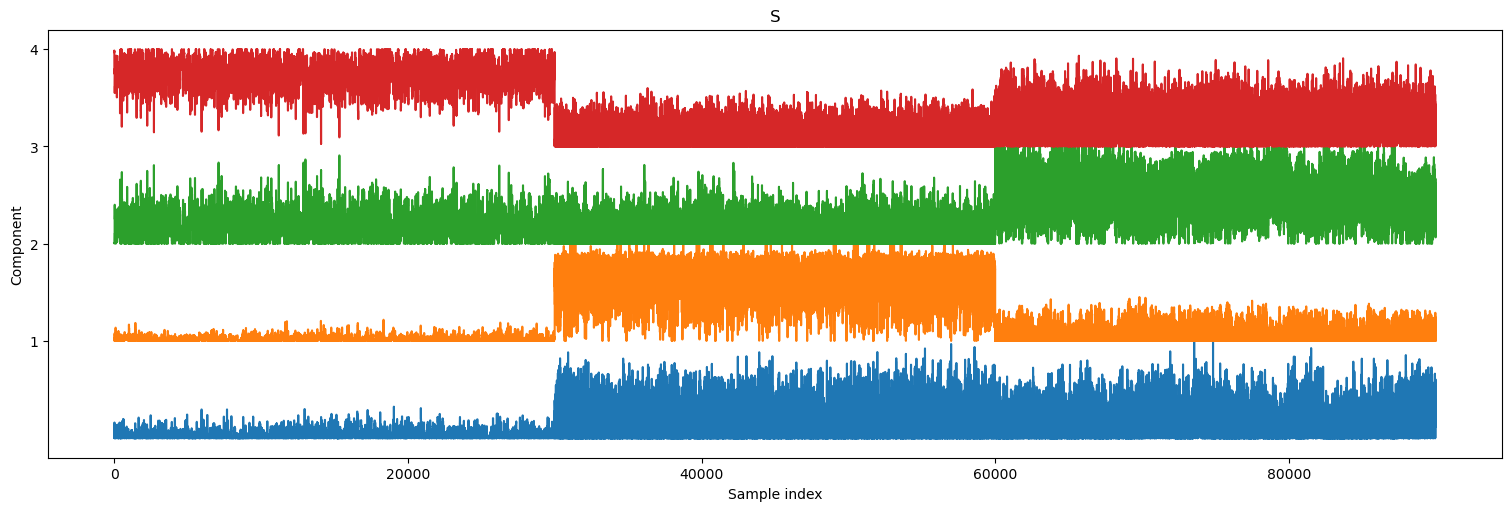

In [21]:
%matplotlib inline
fig, axs = plt.subplots(1,1,figsize=(15,5),layout='constrained')
for k in range(K):
    axs.plot(S[k,:]+k)
axs.set_title('S')
axs.set_yticks([k+1 for k in range(K)])
axs.set_yticklabels([k+1 for k in range(K)])
axs.set_ylabel('Component')
axs.set_xlabel('Sample index')

plt.show()

In [22]:
(X@C@S).shape

(7, 90000)

### Single Archetype plot

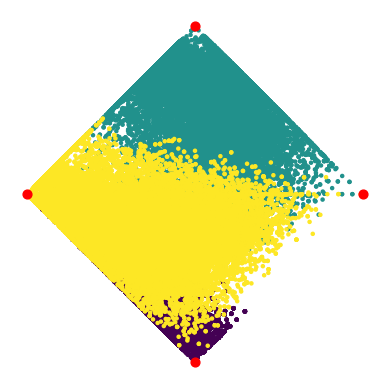

In [23]:
# project the 5 archetypes onto a pentagon graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_axis_off()

xs, ys = np.cos(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5, np.sin(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5
archetypes = np.stack((xs, ys))

distances = np.sqrt(np.sum((archetypes[:, :, np.newaxis] - (archetypes@S)[:, np.newaxis, :])**2, axis=0))
closest_indices = np.argsort(distances, axis=1)[:, :10]
majority_labels = np.array([np.argmax(np.bincount(y[indices])) for indices in closest_indices])
sorted_indices = np.argsort(majority_labels)
sorted_archetypes = archetypes[:, sorted_indices]
sorted_reconstruction = sorted_archetypes@S

# Plotting
plt.scatter(sorted_reconstruction[0, :], sorted_reconstruction[1, :], c=y, s=5)
plt.scatter(sorted_archetypes[0, :], sorted_archetypes[1, :], c='r', s=40, zorder=2)
plt.show()

# AA training for different values of K

In [23]:
from tqdm import tqdm
K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

C_list = []
S_list = []

for K in tqdm(K_list):
    model = AA_model.AA(X=data,num_comp=K,class_weigts=torch.tensor([1, 1, 1]).to(device),model='AA', verbose=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6, disable_output=True)
    C, S = model.get_model_params()
    C_list.append(C)
    S_list.append(S)

100%|██████████| 9/9 [02:47<00:00, 18.63s/it]


In [24]:
# save the two list, they contain the C and S matrices for each K, but they have different shapes, so np.save does not work
import pickle
with open('../src/data/C_list_RMS.pkl', 'wb') as f:
    pickle.dump(C_list, f)
with open('../src/data/S_list_RMS.pkl', 'wb') as f:
    pickle.dump(S_list, f)

### Plotting archetypes for different values of K

In [24]:
# import files again
import pickle
with open('../src/data/C_list_RMS.pkl', 'rb') as f:
    C_list = pickle.load(f)

with open('../src/data/S_list_RMS.pkl', 'rb') as f:
    S_list = pickle.load(f)

K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

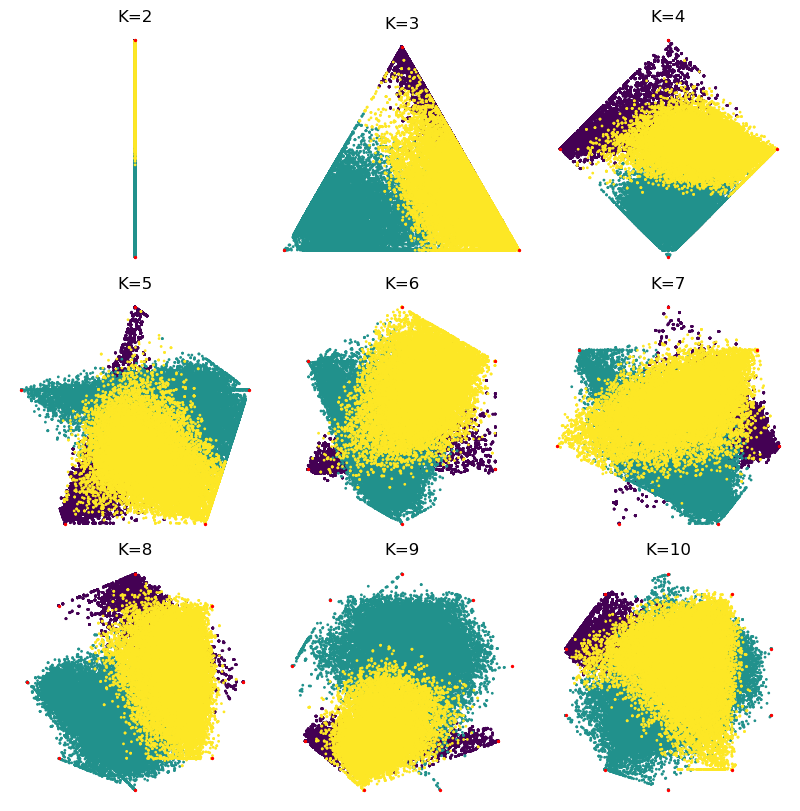

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8), layout='constrained')

for i, K in enumerate(K_list):
    XC = X@C_list[i]
    xs, ys = np.cos(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5, np.sin(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5
    archetypes = np.stack((xs, ys))
    X_reconstructed = archetypes@S_list[i]

    ax = axs[(K-2)//3][(K-2)%3]
    ax.set_aspect('equal')
    ax.set_axis_off()

    distances = np.sqrt(np.sum((archetypes[:, :, np.newaxis] - X_reconstructed[:, np.newaxis, :])**2, axis=0))
    closest_indices = np.argsort(distances, axis=1)[:, :50]
    majority_labels = np.array([np.argmax(np.bincount(y[indices])) for indices in closest_indices])
    sorted_indices = np.argsort(majority_labels)
    sorted_archetypes = archetypes[:, sorted_indices]
    sorted_reconstruction = sorted_archetypes@S_list[i]

    ax.scatter(sorted_archetypes[0,:], sorted_archetypes[1,:], c='r', s=2, zorder=2)
    ax.scatter(sorted_reconstruction[0,:], sorted_reconstruction[1,:], c=y, s=1)
    ax.set_title(f'K={K}')

plt.show()

# Evaluation

In [ ]:
# %%script echo skipping
from tqdm import tqdm
K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
var_explained = []
std_var_explained = []

for K in tqdm(K_list):
    var_explained_K = []
    for i in range(10):
        model = AA_model.AA(X=data,num_comp=K,model='AA', verbose=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6, disable_output=True)
        C, S = model.get_model_params()
        XC = X@C
        X_reconstructed = XC@S
        SSE = np.sum((X - X_reconstructed)**2)
        SST = np.sum((X - np.mean(X, axis=1, keepdims=True))**2)
        var_explained_K.append(1 - (SSE / SST))

    var_explained.append(np.mean(var_explained_K))
    std_var_explained.append(np.std(var_explained_K))

### Variance explained

In [1]:
%%script echo skipping
# save the results
np.save('../src/plot_data/var_explained.npy', var_explained)
np.save('../src/plot_data/std_var_explained.npy', std_var_explained)

Couldn't find program: 'echo'


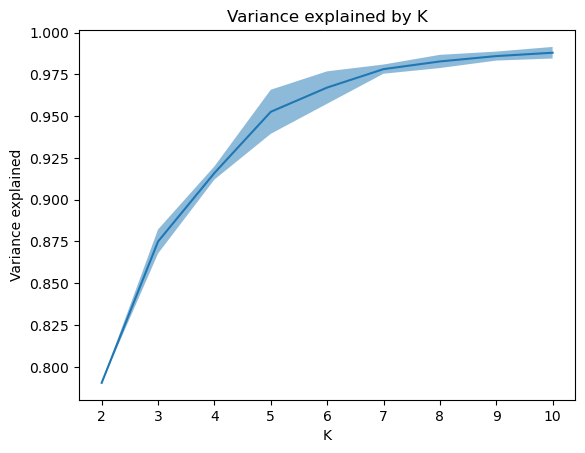

In [26]:
# plot error with fillbetween
var_explained = np.load('../src/plot_data/var_explained.npy')
std_var_explained = np.load('../src/plot_data/std_var_explained.npy')
plt.fill_between(K_list, np.array(var_explained) - np.array(std_var_explained), np.array(var_explained) + np.array(std_var_explained), alpha=0.5)
plt.plot(K_list, var_explained)
plt.xlabel('K')
plt.ylabel('Variance explained')
plt.title('Variance explained by K')
plt.show()

### Classifier on S

In [27]:
%%script echo skipping
# train a classifier on the S matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

acc_list = []
std_acc_list = []

# tqdm
for i, K in enumerate(tqdm(K_list)): 
    acc_list_K = []
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(S_list[i].T, y, test_size=0.2, random_state=42)
        clf = RandomForestClassifier(n_estimators=10)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        acc_list_K.append(acc)
        
    acc_list.append(np.mean(acc_list_K))
    std_acc_list.append(np.std(acc_list_K))

# save the results
np.save('plot_data/acc_list.npy', acc_list)
np.save('plot_data/std_acc_list.npy', std_acc_list)

Couldn't find program: 'echo'


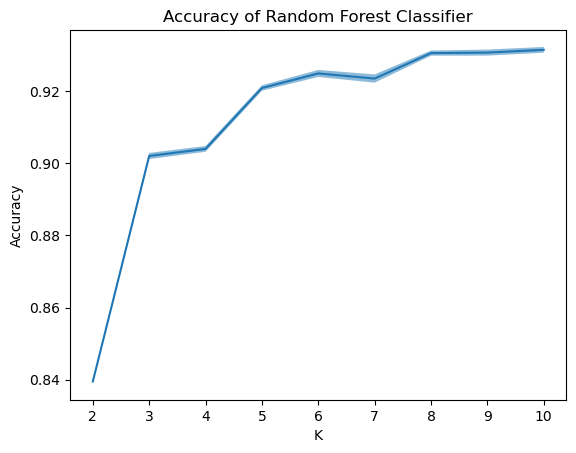

In [28]:
# Plot
import numpy as np
import matplotlib.pyplot as plt
K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
acc_list = np.load('../src/plot_data/acc_list.npy')
std_acc_list = np.load('../src/plot_data/std_acc_list.npy')
plt.fill_between(K_list, np.array(acc_list) - np.array(std_acc_list), np.array(acc_list) + np.array(std_acc_list), alpha=0.5)
plt.plot(K_list, acc_list)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy of Random Forest Classifier')
plt.show()

### Error

In [29]:
errors = X-X@C@S
# max abs error
print('Max abs error:',np.max(np.abs(errors)))
# mean abs error
print('Mean abs error:',np.mean(np.abs(errors)))

Max abs error: 0.5489077544893922
Mean abs error: 0.03853742450415306


### NMI

In [30]:
# NMI, only works with 3 archetypes
# from sklearn.metrics import normalized_mutual_info_score
# # predicted labels
# pred_labels = np.argmax(S,axis=0).flatten()
# # NMI
# NMI = normalized_mutual_info_score(y,pred_labels)
# print('NMI:',NMI)

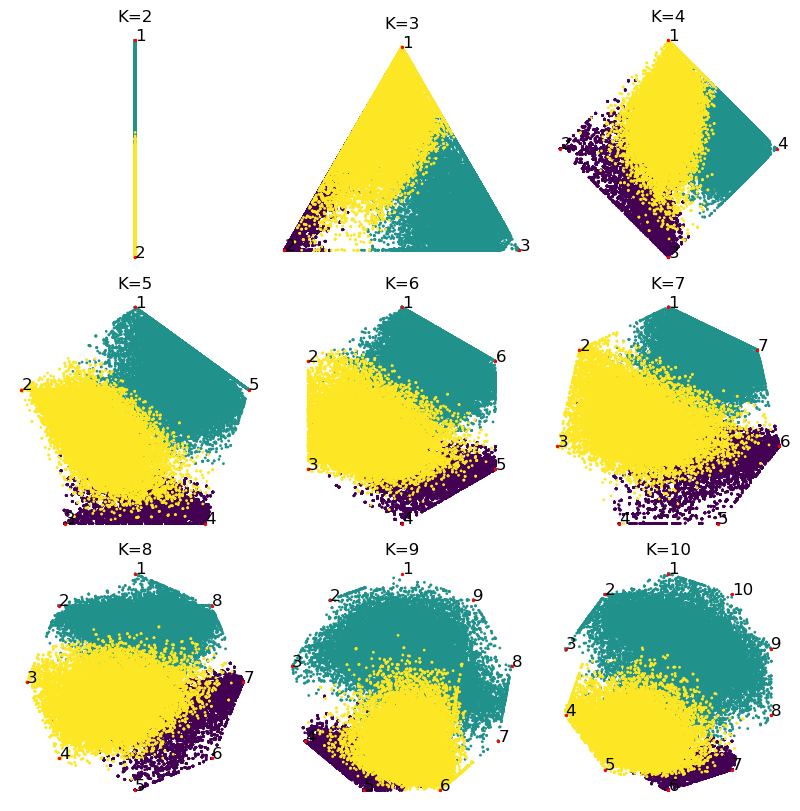

In [31]:

fig, axs = plt.subplots(3, 3, figsize=(8, 8), layout='constrained')

from sklearn.decomposition import PCA

for i, K in enumerate(K_list):
    XC = X@C_list[i]
    xs, ys = np.cos(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5, np.sin(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5
    archetypes = np.stack((xs, ys))

    ax = axs[(K-2)//3][(K-2)%3]
    ax.set_aspect('equal')
    ax.set_axis_off()

    pca = PCA(n_components=2)
    XCS = X @ C_list[i] @ S_list[i]
    
    # Fit PCA on the data points
    pca.fit_transform(XCS.T)
    
    # Transform the archetypes
    XC_pca = pca.transform(XC.T)
    
    # Calculate the angles of the archetypes [0, 2*pi]
    angles = (np.arctan2(XC_pca[:,1],XC_pca[:,0]) + 2*np.pi) % (2*np.pi)
    
    # Sort the archetypes by angle
    sorted_indices = np.argsort(angles)
    
    sorted_archetypes = archetypes[:, np.argsort(sorted_indices)]
    sorted_reconstruction = sorted_archetypes@S_list[i]

    ax.scatter(sorted_archetypes[0,:], sorted_archetypes[1,:], c='r', s=2, zorder=2)
    ax.scatter(sorted_reconstruction[0,:], sorted_reconstruction[1,:], c=y, s=1)
    
    for j in range(K):
        ax.text(archetypes[0,j], archetypes[1,j], str(j+1), fontsize=12, color='black')
    
    ax.set_title(f'K={K}')

plt.show()

C:\Users\AugustPC\AppData\Local\Temp\ipykernel_22696\1101747993.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


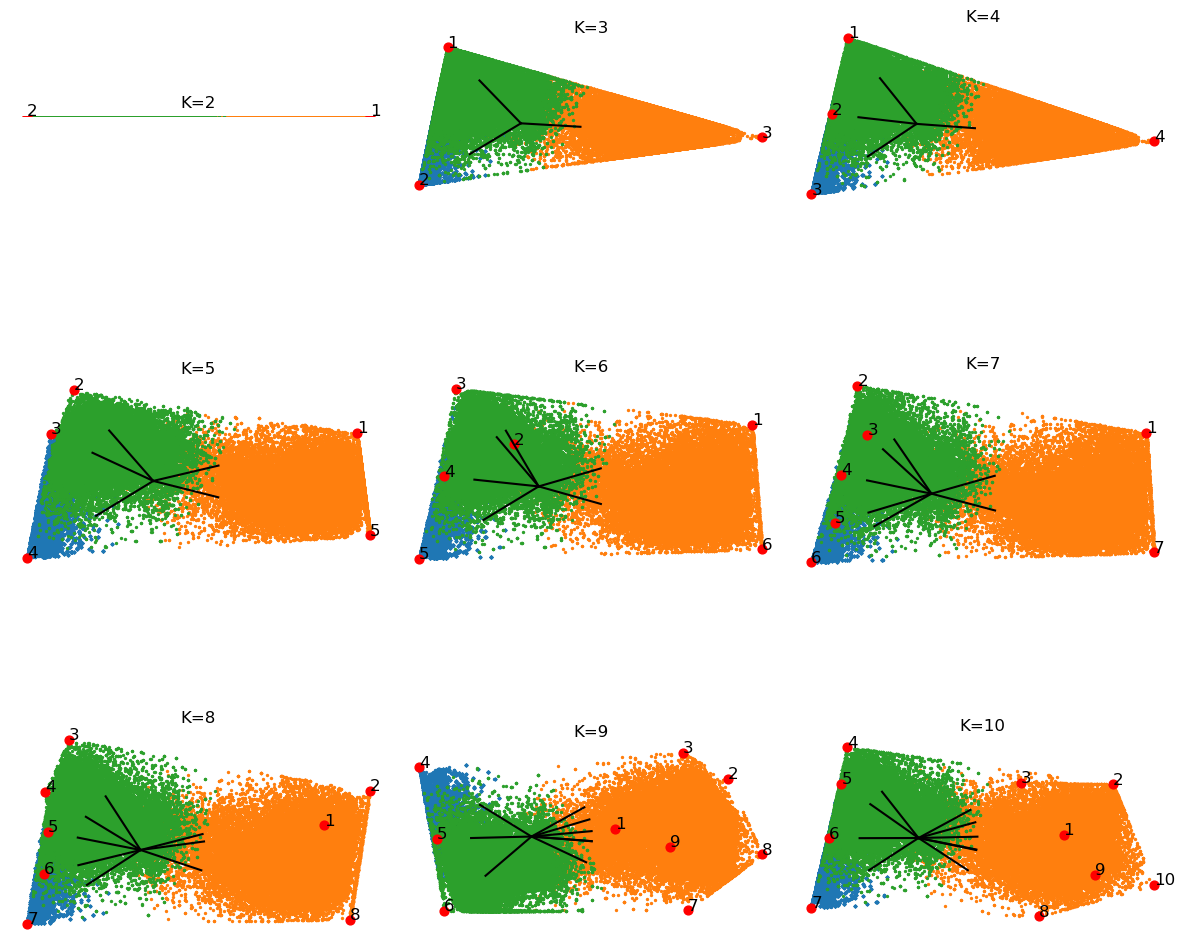

In [32]:
from sklearn.decomposition import PCA

fig, axs = plt.subplots(3, 3, figsize=(12, 12), layout='constrained')
n = 30000

for i, K in enumerate(K_list):
    XC = X@C_list[i]
    xs, ys = np.cos(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5, np.sin(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5
    archetypes = np.stack((xs, ys))
    X_reconstructed = archetypes@S_list[i]

    ax = axs[(K-2)//3][(K-2)%3]
    ax.set_aspect('equal')
    ax.set_axis_off()

    pca = PCA(n_components=2)
    XCS = X @ C_list[i] @ S_list[i]
    
    # Fit PCA on the data points
    XCS_pca = pca.fit_transform(XCS.T)
    
    # Transform the archetypes
    XC_pca = pca.transform(XC.T)
    
    # Calculate the angles of the archetypes [0, 2*pi]
    angles = (np.arctan2(XC_pca[:,1],XC_pca[:,0]) + 2*np.pi) % (2*np.pi)
    
    # Sort the archetypes by angle
    sorted_indices = np.argsort(angles)
    
    # Plot on PCA
    point_size = 2
    ax.scatter(XCS_pca[:n,0],XCS_pca[:n,1],label='Class 1',s=point_size)
    ax.scatter(XCS_pca[n:2*n,0],XCS_pca[n:2*n,1],label='Class 2',s=point_size)
    ax.scatter(XCS_pca[2*n:,0],XCS_pca[2*n:,1],label='Class 3',s=point_size)
    
    # plot XC
    ax.scatter(XC_pca[:,0],XC_pca[:,1],c='r',label='Archetypes',s=40,zorder=2)
    angle_idx = np.argsort(angles)
    angles_sorted = angles[angle_idx]
    for i, angle in enumerate(angles_sorted):
        x_end = np.cos(angle) * 0.3
        y_end = np.sin(angle) * 0.3
        ax.plot([0, x_end], [0, y_end], label=f'Angle: {np.degrees(angle):.0f}°', color='black')
        # show angle idx at point
        XC_pca_sorted = XC_pca[angle_idx]
        ax.text(XC_pca_sorted[i,0], XC_pca_sorted[i,1], str(i+1), fontsize=12)
        
    ax.set_title(f'K={K}')

plt.tight_layout()
plt.show()

In [33]:
from src.utils.AA_visualize import plot_AA, plot_AA_simple, plot_AA_reconstructed, plot_AA_reconstructed_angle, pca_plot_AA

c:\Users\AugustPC\OneDrive\School\4S\Project\sleepy_mice\misc\..\src\utils\AA_visualize.py:450: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


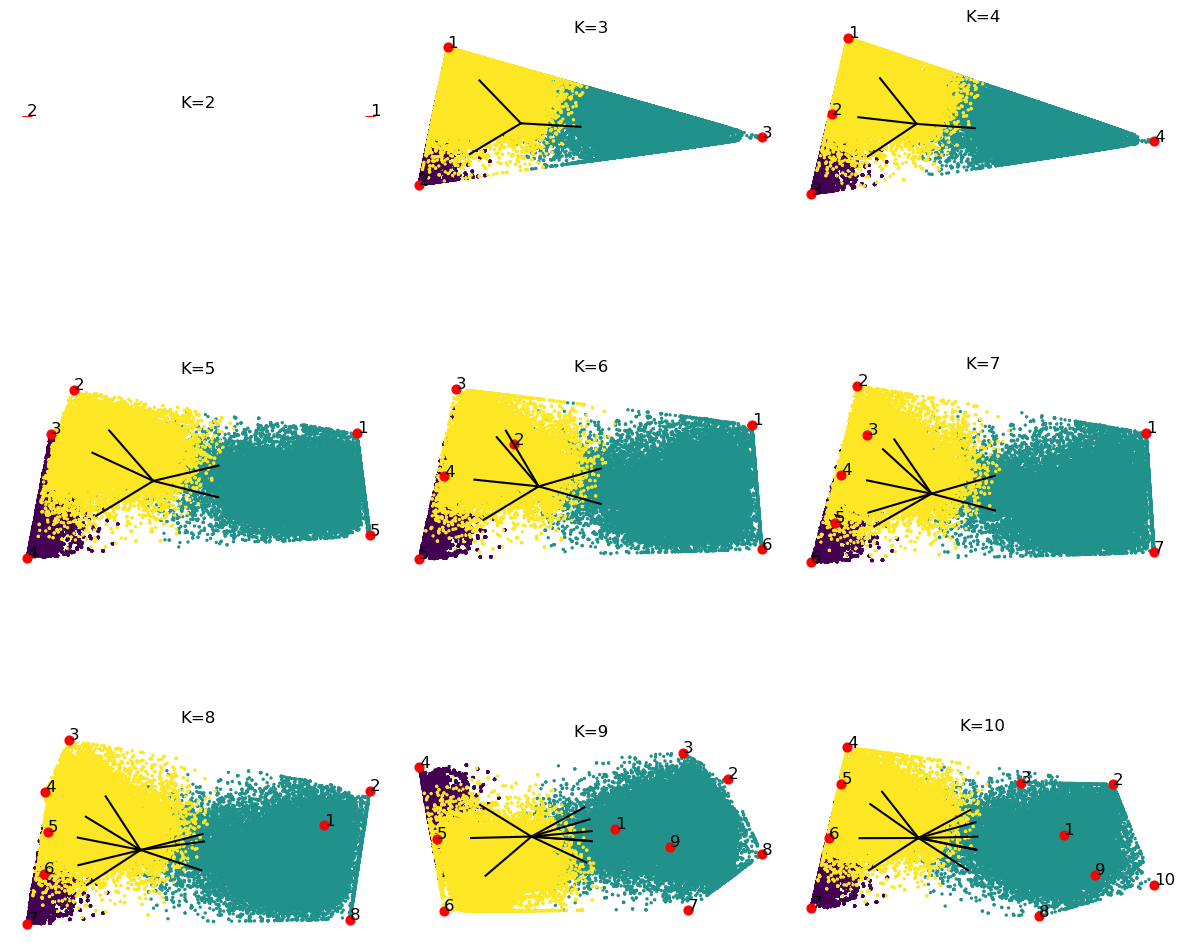

In [34]:
pca_plot_AA(X, C_list, S_list, K_list, y)